In [ ]:
!wget https://pyeeg.googlecode.com/files/pyeeg_v.0.02_r2.py

In [ ]:
!mv pyeeg_v.0.02_r2.py pyeeg.py

In [21]:
import numpy as np
import numpy.random as rng

import theano
import theano.tensor as T

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
sb.set()

import pandas as pd
import timeit
from pyeeg import embed_seq

/home/adrian/Envs/scyfer/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


http://deeplearning.net/software/theano/library/scan.html  
https://github.com/mesnilgr/is13/blob/master/rnn/elman.py  
http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/recurrentNeuralNetworks.php  
http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/  
http://www.nehalemlabs.net/prototype/blog/2013/10/10/implementing-a-recurrent-neural-network-in-python/  

In [8]:
sunspots = sm.datasets.sunspots.load_pandas().data.astype('float32')
scaler = StandardScaler()
ts_train = scaler.fit_transform(sunspots.SUNACTIVITY)
x_train = embed_seq(ts_train, 1, 11)

rng = np.random
dtype = theano.config.floatX
n_samples, nn_input_dim = x_train.shape
nn_output_dim = nn_input_dim
n_h_dim = 5

# Initialize Theano symbolic variables for the LSTM memory cell
inputs = T.matrix(dtype=dtype)
targets = T.matrix(dtype=dtype)
num_epochs = T.iscalar()

In [9]:
# weights generator
def ortho_weights(sizeX, sizeY):
    W = rng.uniform(low=-1., high=1.,  size=(sizeX, sizeY)).astype(dtype)
    s = np.linalg.svd(W)[1]
    W /= s[0]
    return W.astype(dtype)

In [41]:
# parameters for in, out & forget gates:
# stacked input-to-hidden unit weights
Whx = theano.shared(ortho_weights(n_h_dim, nn_input_dim), name='Whx')
# stacked hidden-to-hidden unit weights
Whh = theano.shared(ortho_weights(n_h_dim, n_h_dim), name='Whh')
# vector of stacked biases
bh = theano.shared(np.zeros(n_h_dim,dtype=dtype), name='bh')
# parameters for autoeconder ouput
Wyh = theano.shared(ortho_weights(nn_output_dim, n_h_dim), name='Wyh')  # stacked input-to-hidden unit weights
by = theano.shared(np.zeros(nn_output_dim, dtype=dtype), name='by')   

# initial values for h and c
h0 = theano.shared(value=np.zeros(n_h_dim, dtype=dtype)) # vector of initial values for memory cells

# deep learning LSTM tutorial, when used directly in scan's outputs_info for h0, c0
# [tensor.alloc(0., n_samples, n_h_dim), tensor.alloc(0., n_samples, n_h_dim)]

pars = [Whx, Whh, Wyh, bh, by]

def elman_step(x_t, h_tm1, Whx, Whh, Wyh, bh, by):
    # preact = x_t + h_tm1 # tensor.dot(h_, tpars[_p(prefix, 'U')]) orthogonalized h
    pre_h = Whx.dot(x_t) + Whh.dot(h_tm1) + bh
    h = T.nnet.sigmoid(pre_h)
    y = Wyh.dot(h) + by # regression
    # RNN classification output y = T.nnet.softmax(Wyh.dot(h) + by)[0]
    return [h, y]

[h_vals, y_vals] = theano.scan(fn=elman_step,
                              sequences=[dict(input=inputs, taps=[0])],
                              outputs_info=[h0, None],
                              non_sequences=[Whx, Whh, Wyh, bh, by],
                              strict=True)[0]

#  + weight_regularization * (w ** 2).sum() + hidden_regularization * T.abs(w).sum() ADD all weights
cost = ((inputs - y_vals)**2).mean(axis=0).sum() # regression

# learning rate
lr = 0.1
learning_rate = theano.shared(np.cast[dtype](lr))

# gradients
gpars = []
for par in pars:
    gpar = T.grad(cost, par)
    gpars.append(gpar)

# pars updates
updates=[]
for par, gpar in zip(pars, gpars):
    updates.append((par, par - gpar * learning_rate))

# compile traning function
learn_elman_rnn = theano.function(inputs=[inputs],
                                 outputs=[h_vals, cost],
                                 updates=updates,
                                 allow_input_downcast=True
                                  )

# prediction function
forecast = Wyh.dot(h_vals.T).T + by
predict_elman_rnn = theano.function(inputs=[inputs],
                                   outputs=forecast,
                                   allow_input_downcast=True
                                  )

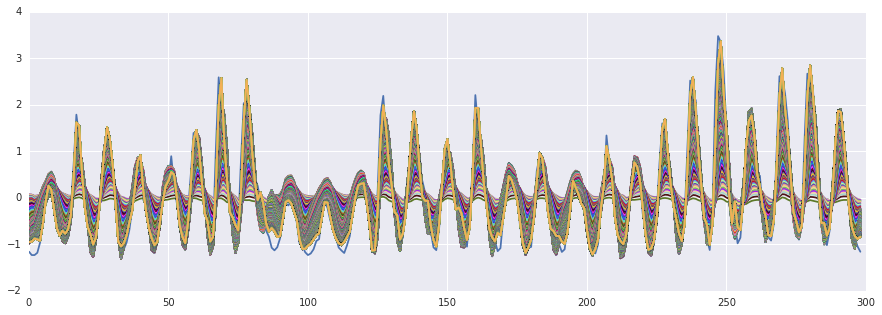

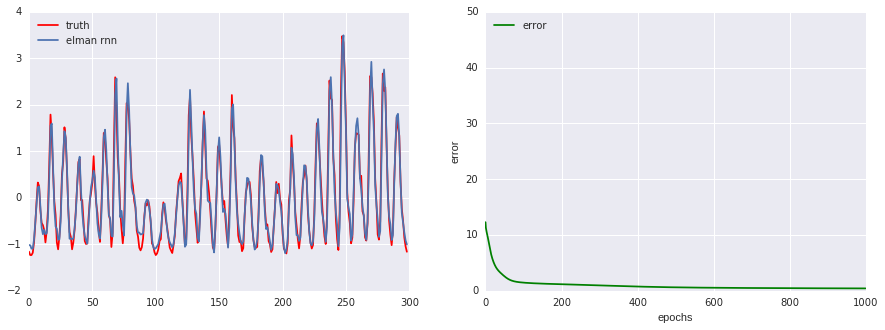

In [42]:
# visualize training epochs
plt.figure(0, figsize=[15,5])
plt.plot(x_train[:,-1])
n_epochs=1000
train_errors = []
for x in xrange(n_epochs):
    train_errors.append(np.asscalar(learn_elman_rnn(x_train)[1]))
    if x % 100:
        plt.plot(predict_elman_rnn(x_train)[:,-1], color=np.random.rand(3,1))
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5], num=1)
ax1.plot(x_train[:,-1], 'r-', label='truth')
ax1.plot(predict_rnn(x_train)[:,-1], label='elman rnn')
ax1.legend(loc=2)
ax2.plot(np.arange(n_epochs), train_errors, 'g-')
ax2.set_xlabel('epochs')
ax2.set_ylabel('error')
ax2.set_ylim(0., 50)
ax2.legend(['error'], loc=2)
fig.show()